# Importing Neccesary Packages

In [2]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import subplots, show
import seaborn as sns
%matplotlib  inline
import re
import os
import pickle

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

# Importing train and test data set

In [3]:
df_train = pd.read_csv('../wallboard_train.csv')
df_test =  pd.read_csv('../wallboard_test.csv')

# setting asset_id as index
df_train.set_index('asset_id',inplace = True)
df_test.set_index('asset_id',inplace = True)

print('Train data set shape:', df_train.shape)
print('Test data set shapec:', df_test.shape)

# Removing 'clinic_had_mia' column

df_train.drop('clinic_had_mia',1,inplace=True)
df_train.drop('sku_P-WAL-107-ELC-03',1,inplace=True)
df_train.drop('sku_P-WAL-106-ELC-01',1,inplace=True)

df_test.drop('clinic_had_mia',1,inplace=True)
df_test.drop('sku_P-WAL-107-ELC-03',1,inplace=True)
df_test.drop('sku_P-WAL-106-ELC-01',1,inplace=True)


# Removing variables that had prevalance greater than 85% around the same type of devices and device count < 200

prev_cols = ['software_version_2.0.3', 'software_version_3.3.1',
       'software_version_3.5', 'software_version_4.10.1',
       'software_version_4.2.2', 'software_version_4.3.2',
       'software_version_4.3.3', 'software_version_4.5.1',
       'model_UIT232B-B06', 'sku_P-WAL-104-OUT-01',
       'is_battery_charging_False', 'specialty_Critical Care Medicine',
       'specialty_Hepatology', 'specialty_Otolaryngology',
       'specialty_Pathology']

for col in prev_cols:
    df_train.drop(col,1,inplace=True)
    df_test.drop(col,1,inplace=True)


# Splitting the train and test data to X ( independent variables ) and y ( dependent variables ) set
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]
print('\n')
print('Sneak peak of y train')
print("---------------------")
print(y_train.head(3))
print('\n')
print('Sneak peak of X train')
print("---------------------")
X_train.head(3)

Train data set shape: (12369, 460)
Test data set shapec: (4123, 460)


Sneak peak of y train
---------------------
asset_id
W01Y107687    1
W01E106713    0
W01E121261    1
Name: y_flag, dtype: int64


Sneak peak of X train
---------------------


,software_version_3.0.1,software_version_3.2,software_version_3.3.2,software_version_4.10.2,software_version_4.12.4,software_version_4.3.1,software_version_4.4,software_version_4.4.1,software_version_4.6,software_version_4.7.7,...,Varicose Veins,Vasculature,Ventral Hernia,Ventricular Fibrillation with Conduction System,Wagner Classification,Warts on Skin,Whiteboard,Wrist,avg_times,avg_days
asset_id,,,,,,,,,,,,,,,,,,,,,
W01Y107687,0,0,0,0,0,0,0,0,1,0,...,-0.150889,-0.260727,-0.082145,-0.090345,-0.211962,-0.123294,-0.011374,-0.197531,1.322661,0.137164
W01E106713,0,0,0,1,1,0,0,0,0,1,...,-0.150889,-0.260727,-0.082145,-0.090345,-0.211962,-0.123294,-0.011374,-0.197531,-0.314780,-0.218282
W01E121261,0,0,0,1,0,0,0,0,0,0,...,-0.150889,-0.260727,-0.082145,-0.090345,-0.211962,-0.123294,-0.011374,-0.197531,0.340196,-0.167504


# Feature Reduction

In [4]:
threshold_n = 0.9
sel = VarianceThreshold(threshold=(threshold_n * (1 - threshold_n) ))
sel_var = sel.fit_transform(X_train)
X_train_fs = X_train[X_train.columns[sel.get_support(indices=True)]]
X_test_fs = X_test[X_test.columns[sel.get_support(indices=True)]]

print("Shape of the train and test data sets post feature selection: ", X_train_fs.shape, X_test_fs.shape)

Shape of the train and test data sets post feature selection:  (12369, 329) (4123, 329)


In [4]:
#get correlations of each features in dataset
data = pd.concat([X_train_fs,y_train],axis = 1)
corrmat = data.corr()
top_corr_features = corrmat.index

In [5]:
corrmat.loc['y_flag',:'clinic_had_mia'][corrmat.loc['y_flag',:'clinic_had_mia'] > 0]

manufacturer_OUTFORM                0.453410
manufacturer_YITOA                  0.252483
model_UIT232B-W01                   0.442524
sku_P-WAL-105-OUT-01                0.442524
state_Texas                         0.008597
facility_type_Private Group         0.063007
facility_type_Private Practice      0.097481
ranking_6.0                         0.031684
ranking_7.0                         0.001578
ranking_8.0                         0.002111
ranking_9.0                         0.008544
ranking_10.0                        0.037433
specialty_Cardiovascular Disease    0.065188
fs_pct_0.0261_0.0613                0.300752
fs_pct_0.0613_0.0661                0.028797
SEPT_avg_video_duration             0.007577
OCT_avg_video_duration              0.031232
jun_avg_Crash_sessions              0.022411
jul_avg_Crash_sessions              0.015782
aug_avg_Crash_sessions              0.009044
sept_avg_Crash_sessions             0.006664
oct_avg_Crash_sessions              0.011392
Heart Atta

# Baseline Models

## 5 fold Cross Validation of all baseline models

In [6]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [7]:
def kfold_cv(X,y,k = 3,model = 'logistic'):
    scores = []
    train_acc = []
    fpr = []
    
    if 'logistic' in str.lower(model):
        curr_model = LogisticRegression()
    elif 'naive' in str.lower(model) or 'bayes' in str.lower(model):
        curr_model = GaussianNB()
    elif 'decision' in str.lower(model) or 'tree' in str.lower(model):
        curr_model = DecisionTreeClassifier()
    elif 'SVM' in str.upper(model):
        curr_model = LinearSVC()
    elif 'random' in str.lower(model) or 'forest' in str.lower(model):
        curr_model = RandomForestClassifier()    
        
    cv = KFold(n_splits=k, random_state=42, shuffle=False)
    for train_index, test_index in cv.split(X):

        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        curr_model.fit(X_train, y_train)
        # Test Accuracy
        scores.append(curr_model.score(X_test, y_test))
        # Train Accuracy
        train_acc.append(accuracy_score(y_train, curr_model.predict(X_train)))
        # Calculating False positive rate
        CM = confusion_matrix(y_test, curr_model.predict(X_test))
        TN = CM[0][0]
        FN = CM[1][0]
        TP = CM[1][1]
        FP = CM[0][1]
        # False positive rate
        FPR = FP/(FP+TN)
        fpr.append(FPR)
    
    # Training accuracies
    print('Displaying Training accuracies of %s model in %d fold cv'%(model, k))
    print('------------------------------------------------------------------------------')
    train_acc = np.array(train_acc)
    display_scores(train_acc)
    print('\n')
    # Testing accuracies
    print('Displaying Testing accuracies of %s model in %d fold cv'%(model, k))
    print('------------------------------------------------------------------------------')
    scores = np.array(scores)
    display_scores(scores)
    print('\n')
    # False Positive Rate
    print('Displaying False Positive Rate of %s model in %d fold cv'%(model, k))
    print('------------------------------------------------------------------------------')
    fpr = np.array(fpr)
    display_scores(fpr)

### Naive Bayes 

In [8]:
kfold_cv(X_train_fs,y_train, k=5 ,model = 'Naive')

Displaying Training accuracies of Naive model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.72410308 0.83385548 0.80101061 0.83516928 0.82770816]
Mean: 0.8043693237359291
Standard Deviation: 0.04199219610584921


Displaying Testing accuracies of Naive model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.7178658  0.82700081 0.78940986 0.84721099 0.82652649]
Mean: 0.8016027911468109
Standard Deviation: 0.045840830074230655


Displaying False Positive Rate of Naive model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.40375204 0.15806195 0.22986577 0.13155834 0.16129032]
Mean: 0.21690568546703504
Standard Deviation: 0.09891344342974709


## Logistic Regression 

In [9]:
kfold_cv(X_train_fs,y_train, k=5 ,model = 'Logistic')

Displaying Training accuracies of Logistic model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.96523497 0.96533603 0.96382011 0.96503284 0.96483428]
Mean: 0.9648516455931991
Standard Deviation: 0.0005438308855125814


Displaying Testing accuracies of Logistic model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.9458367  0.95311237 0.94745352 0.95270816 0.95511524]
Mean: 0.9508451992922105
Standard Deviation: 0.0035618125962154296


Displaying False Positive Rate of Logistic model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.06362153 0.06592534 0.05956376 0.05951449 0.0516129 ]
Mean: 0.06004760394114951
Standard Deviation: 0.004878180417893898


## SVM

In [10]:
kfold_cv(X_train_fs,y_train, k=5 ,model = 'svm')

Displaying Training accuracies of svm model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.96483072 0.96270844 0.96291056 0.96220313 0.9614996 ]
Mean: 0.9628304901547086
Standard Deviation: 0.0011123933307237743


Displaying Testing accuracies of svm model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.95028294 0.95109135 0.95392078 0.95594179 0.95592398]
Mean: 0.95343216847041
Standard Deviation: 0.002372472764339126


Displaying False Positive Rate of svm model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.06443719 0.0675139  0.05536913 0.0587314  0.05806452]
Mean: 0.060823227883282704
Standard Deviation: 0.004462270327080594


## Decision Tree

In [11]:
kfold_cv(X_train_fs,y_train, k=5 ,model = 'decisiontree')

Displaying Training accuracies of decisiontree model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.99909045 0.99888833 0.99868621 0.99878727 0.99868634]
Mean: 0.9988277173049436
Standard Deviation: 0.000151229637505189


Displaying Testing accuracies of decisiontree model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.94381568 0.95230396 0.95189976 0.95392078 0.95268904]
Mean: 0.9509258438998909
Standard Deviation: 0.0036188557997062828


Displaying False Positive Rate of decisiontree model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.05057096 0.05242256 0.03942953 0.04933438 0.04274194]
Mean: 0.04689987263946974
Standard Deviation: 0.004959802835145495


## Random Forest

In [12]:
kfold_cv(X_train_fs,y_train, k=5 ,model = 'forest')

Displaying Training accuracies of forest model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.99909045 0.99888833 0.99868621 0.99878727 0.99868634]
Mean: 0.9988277173049436
Standard Deviation: 0.000151229637505189


Displaying Testing accuracies of forest model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.96887631 0.96645109 0.97170574 0.9672595  0.9692681 ]
Mean: 0.9687121477845944
Standard Deviation: 0.001817701077884587


Displaying False Positive Rate of forest model in 5 fold cv
------------------------------------------------------------------------------
Scores: [0.05138662 0.06036537 0.04949664 0.05403289 0.05241935]
Mean: 0.053540176244897306
Standard Deviation: 0.0037167246158958285


# First run Final Models  - Grid Searched hyperparameter tuned 

In [13]:
def plot_auc(clf,X_test,y_test):
    fig, ax = subplots()
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC: ",auc)
    ax.plot(fpr,tpr,label="auc="+str(auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve (Test), AUC = %.4f'%auc)
    ax.legend(loc='best')
    plt.show()

## Logistic Regression

In [14]:
param_grid = {"C":np.logspace(-3,3,7), 
              "penalty":["l1","l2"]} # l1 lasso l2 ridge

logreg = LogisticRegression()

logreg_cv = GridSearchCV(logreg,param_grid,cv=5)
# fit data
logreg_cv.fit(X_train_fs,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [15]:
params = logreg_cv.best_params_
final_model_logreg = LogisticRegression(C=params['C'],penalty= params['penalty'])
final_model_logreg.fit(X_train_fs,y_train)
print("Training accuracy :", final_model_logreg.score(X_train_fs,y_train))
print("Testing accuracy :", final_model_logreg.score(X_test_fs,y_test))

Training accuracy : 0.9639421133478858
Testing accuracy : 0.9507640067911715


In [16]:
predictions = final_model_logreg.predict(X_test_fs)
print("Test Dataset")
print(classification_report(y_test, predictions))

Test Dataset
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2046
           1       0.93      0.97      0.95      2077

    accuracy                           0.95      4123
   macro avg       0.95      0.95      0.95      4123
weighted avg       0.95      0.95      0.95      4123



AUC:  0.9804953098475083


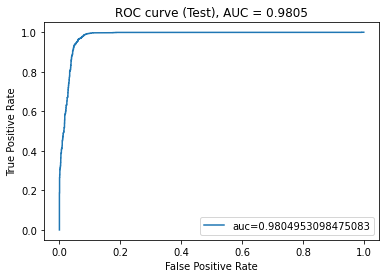

In [17]:
plot_auc(final_model_logreg,X_test_fs,y_test)

In [18]:
CM = confusion_matrix(y_test, final_model_logreg.predict(X_test_fs))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# False positive rate
FPR = FP/(FP+TN)

print('Confusion Matrix:')
print('-----------------')
print(CM)
print('\n')
print('False positive rate - ',FPR)

Confusion Matrix:
-----------------
[[1898  148]
 [  55 2022]]


False positive rate -  0.07233626588465299


<Figure size 432x432 with 0 Axes>

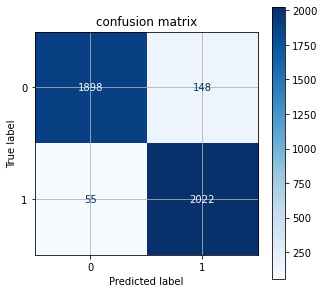

In [19]:
# Plot confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model_logreg, X_test_fs,y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
#                              normalize="true")
disp.ax_.set_title("confusion matrix")

plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [20]:
feature_importance = abs(final_model_logreg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.sum())
sorted_feat_imp_logreg = list(zip(X_test_fs.columns,feature_importance))
sorted_feat_imp_logreg.sort(key=lambda x: x[1],reverse = True)
pd.DataFrame(sorted_feat_imp_logreg, columns = ['feature','importance']).to_csv('../first_run_logistic_fi.csv')

In [21]:
# save the model to disk
filename = '../first_run_grid_cv_logistic.sav'
pickle.dump(final_model_logreg, open(filename, 'wb'))

In [22]:
final_model_logreg.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
#####     QC
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## SVM

In [22]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}

svm_search = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=5)

# fit data
svm_search.fit(X_train_fs,y_train)

svm_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.501, total= 1.0min
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.501, total= 1.0min
[CV] C=0.001, gamma=1, kernel=rbf ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.501, total= 1.0min
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.501, total= 1.0min
[CV] C=0.001, gamma=1, kernel=rbf ....................................
[CV] ........ C=0.001, gamma=1, kernel=rbf, score=0.501, total= 1.1min
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.960, total=  22.8s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.958, total=  22.6s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.959, total=  22.5s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] ..... C=0.001, gamma=1, kernel=linear, score=0.956, total=  22.9s
[CV] C=0.001, gamma=1, kernel=linear .................................
[CV] .

[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.610, total=  58.6s
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.592, total= 1.0min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.591, total= 1.0min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.606, total= 1.0min
[CV] C=0.01, gamma=0.1, kernel=rbf ...................................
[CV] ....... C=0.01, gamma=0.1, kernel=rbf, score=0.592, total= 1.0min
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.963, total=  12.0s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .... C=0.01, gamma=0.1, kernel=linear, score=0.959, total=  10.6s
[CV] C=0.01, gamma=0.1, kernel=linear ................................
[CV] .

[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.962, total=  12.9s
[CV] C=0.1, gamma=0.1, kernel=linear .................................
[CV] ..... C=0.1, gamma=0.1, kernel=linear, score=0.967, total=  11.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.799, total=  38.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.793, total=  41.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.780, total=  46.4s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.817, total=  47.2s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.797, total=  46.8s
[CV] C=0.1, gamma=0.01, kernel=linear ................................
[CV] .

[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.965, total=  31.8s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.961, total=  33.5s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.961, total=  38.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ...... C=1, gamma=0.01, kernel=linear, score=0.963, total=  33.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.947, total=  22.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.946, total=  22.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........ C=1, gamma=0.001, kernel=rbf, score=0.949, total=  22.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.958, total= 5.8min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.954, total=57.8min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.965, total= 4.2min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.959, total= 3.2min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ... C=10, gamma=0.001, kernel=linear, score=0.962, total=101.9min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] .... C=10, gamma=0.001, kernel=linear, score=0.964, total= 4.0min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.961, total=  16.7s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 767.3min finished


{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}

In [24]:
# params_svm = svm_search.best_params_
params_svm = {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
final_model_svm = SVC(C=params_svm['C'],kernel = params_svm['kernel'],gamma= params_svm['gamma'],probability=True)

# fit data
final_model_svm.fit(X_train_fs,y_train)

SVC(C=0.1, gamma=1, kernel='linear', probability=True)

In [25]:
print("Training accuracy :", final_model_svm.score(X_train_fs,y_train))
print("Testing accuracy :", final_model_svm.score(X_test_fs,y_test))

predictions = final_model_svm.predict(X_test_fs)
print("Test Dataset")
print(classification_report(y_test, predictions))

Training accuracy : 0.9649122807017544
Testing accuracy : 0.9539170506912442
Test Dataset
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2046
           1       0.93      0.98      0.96      2077

    accuracy                           0.95      4123
   macro avg       0.96      0.95      0.95      4123
weighted avg       0.96      0.95      0.95      4123



AUC:  0.979784409708152


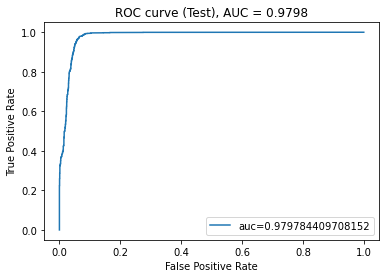

In [26]:
plot_auc(final_model_svm,X_test_fs,y_test)

Confusion Matrix:
-----------------
[[1897  149]
 [  41 2036]]


False positive rate -  0.07282502443792767


<Figure size 432x432 with 0 Axes>

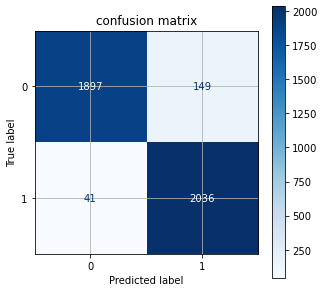

In [27]:
CM = confusion_matrix(y_test, final_model_svm.predict(X_test_fs))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# False positive rate
FPR = FP/(FP+TN)

print('Confusion Matrix:')
print('-----------------')
print(CM)
print('\n')
print('False positive rate - ',FPR)

# Plot confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model_svm, X_test_fs,y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
#                              normalize="true")
disp.ax_.set_title("confusion matrix")
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [28]:
feature_importance = abs(final_model_svm.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.sum())
sorted_feat_imp_svm = list(zip(X_test_fs.columns,feature_importance))
sorted_feat_imp_svm.sort(key=lambda x: x[1],reverse = True)
pd.DataFrame(sorted_feat_imp_svm, columns = ['feature','importance']).to_csv('../first_run_svm_fi.csv')

In [29]:
# save the model to disk
filename = '../first_run_grid_cv_svm.sav'
pickle.dump(final_model_svm, open(filename, 'wb'))

In [30]:
final_model_svm.get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [31]:
#####     QC
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.get_params()

{'C': 0.1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Decision Tree

In [32]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth': range(1,10),
    'min_samples_leaf': range(1,10),
    'min_samples_split': range(1,5)
}

dt_clf = DecisionTreeClassifier()
DT_search = GridSearchCV(dt_clf, param_grid=param_grid, cv=5, verbose = 1, n_jobs = -1)
DT_search.fit(X_train_fs,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 5)},
             verbose=1)

In [33]:
params_dt = DT_search.best_params_

final_model_dt = DecisionTreeClassifier(criterion = params_dt['criterion'],
                                         max_depth = params_dt['max_depth'],
                                         min_samples_leaf = params_dt['min_samples_leaf'],
                                         min_samples_split = params_dt['min_samples_split'])

# fit data
final_model_dt.fit(X_train_fs,y_train)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=9)

In [34]:
print("Training accuracy :", final_model_dt.score(X_train_fs,y_train))
print("Testing accuracy :", final_model_dt.score(X_test_fs,y_test))

predictions = final_model_dt.predict(X_test_fs)
print("Test Dataset")
print(classification_report(y_test, predictions))

Training accuracy : 0.9675802409248929
Testing accuracy : 0.9599805966529227
Test Dataset
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2046
           1       0.94      0.98      0.96      2077

    accuracy                           0.96      4123
   macro avg       0.96      0.96      0.96      4123
weighted avg       0.96      0.96      0.96      4123



AUC:  0.9865309014477325


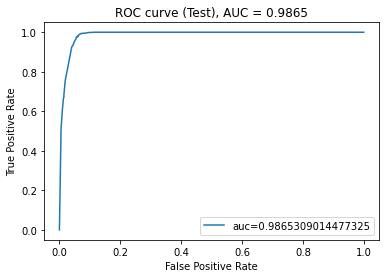

In [35]:
plot_auc(final_model_dt,X_test_fs,y_test)

Confusion Matrix:
-----------------
[[1923  123]
 [  42 2035]]


False positive rate -  0.060117302052785926


<Figure size 432x432 with 0 Axes>

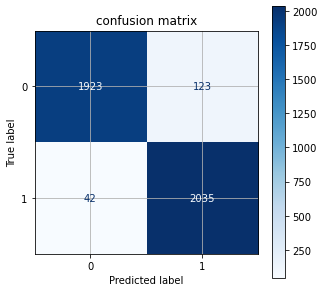

In [36]:
CM = confusion_matrix(y_test, final_model_dt.predict(X_test_fs))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# False positive rate
FPR = FP/(FP+TN)

print('Confusion Matrix:')
print('-----------------')
print(CM)
print('\n')
print('False positive rate - ',FPR)

# Plot confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model_dt, X_test_fs,y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
#                              normalize="true")
disp.ax_.set_title("confusion matrix")
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [37]:
sorted_feat_imp_dt = list(zip(X_test_fs.columns,final_model_dt.feature_importances_))
sorted_feat_imp_dt.sort(key=lambda x: x[1],reverse = True)
pd.DataFrame(sorted_feat_imp_dt,columns = ['feature','importance']).to_csv('../first_run_dt_fi.csv')

In [38]:
# save the model to disk
filename = '../first_run_grid_cv_dt.sav'
pickle.dump(final_model_dt, open(filename, 'wb'))

## Random Forest 

In [39]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'min_samples_leaf': range(1,10),
    'min_samples_split': range(1,5),
    'n_estimators': [300, 500]
}

forest_reg = RandomForestClassifier(random_state=42, class_weight="balanced")
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_grid,
                                n_iter=5, cv=5, scoring='f1_weighted', random_state=42)
rnd_search.fit(X_train_fs,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 5),
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

In [40]:
final_model_rf = rnd_search.best_estimator_

In [41]:
final_model_rf

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_leaf=2, n_estimators=300, random_state=42)

In [42]:
print("Training accuracy :", final_model_rf.score(X_train_fs,y_train))
print("Testing accuracy :", final_model_rf.score(X_test_fs,y_test))
print('\n')
predictions_train = final_model_rf.predict(X_test_fs)
print("Test Dataset")
print(classification_report(y_test, predictions_train))

Training accuracy : 0.9843964750586143
Testing accuracy : 0.9674993936454038


Test Dataset
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2046
           1       0.94      0.99      0.97      2077

    accuracy                           0.97      4123
   macro avg       0.97      0.97      0.97      4123
weighted avg       0.97      0.97      0.97      4123



AUC:  0.9904935637769906


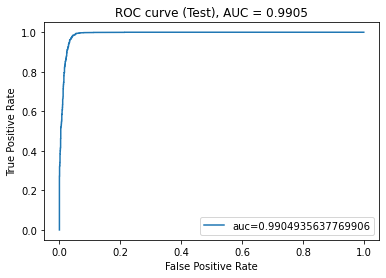

In [43]:
plot_auc(final_model_rf,X_test_fs,y_test)

Confusion Matrix:
-----------------
[[1923  123]
 [  42 2035]]


False positive rate -  0.060117302052785926


<Figure size 432x432 with 0 Axes>

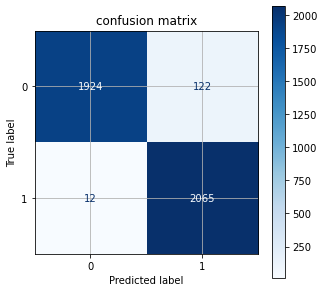

In [44]:
# CM = confusion_matrix(y_test, final_model_rf.predict(X_test_fs))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# False positive rate
FPR = FP/(FP+TN)

print('Confusion Matrix:')
print('-----------------')
print(CM)
print('\n')
print('False positive rate - ',FPR)

# Plot confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model_rf, X_test_fs,y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
disp.ax_.set_title("confusion matrix")
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [45]:
sorted_feat_imp_rf = list(zip(X_test_fs.columns,final_model_rf.feature_importances_))
sorted_feat_imp_rf.sort(key=lambda x: x[1],reverse = True)
pd.DataFrame(sorted_feat_imp_rf,columns = ['feature','importance']).to_csv('../first_run_rf_fi.csv')

In [46]:
# save the model to disk
filename = '../first_run_grid_cv_rf.sav'
pickle.dump(final_model_rf, open(filename, 'wb'))

# Running Random Forest model excluding software version

In [47]:
columns_1 = X_train_fs.columns

columns_1 = [x for x in columns_1 if 'software_' not in x]
# columns_1.remove('sku_P-WAL-107-ELC-03')
# columns_1.remove('sku_P-WAL-106-ELC-01')


X_train_fs_sf = X_train_fs[columns_1]
X_test_fs_sf = X_test_fs[columns_1]


In [48]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100],
    'min_samples_leaf': range(1,10),
    'min_samples_split': range(1,5),
    'n_estimators': [300, 500]
}

forest_reg_sf = RandomForestClassifier(random_state=42, class_weight="balanced")
rnd_search_sf = RandomizedSearchCV(forest_reg_sf, param_distributions=param_grid,
                                n_iter=5, cv=5, scoring='f1_weighted', random_state=42)

rnd_search_sf.fit(X_train_fs_sf,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(1, 5),
                                        'n_estimators': [300, 500]},
                   random_state=42, scoring='f1_weighted')

In [49]:
final_model_rf_sf = rnd_search_sf.best_estimator_

In [50]:
final_model_rf_sf

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_leaf=2, n_estimators=300, random_state=42)

In [51]:
print("Training accuracy :", final_model_rf_sf.score(X_train_fs_sf,y_train))
print("Testing accuracy :", final_model_rf_sf.score(X_test_fs_sf,y_test))
print('\n')
predictions_train = final_model_rf_sf.predict(X_test_fs_sf)
print("Test Dataset")
print(classification_report(y_test, predictions_train))

Training accuracy : 0.9680653246018271
Testing accuracy : 0.8983749696822702


Test Dataset
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2046
           1       0.93      0.87      0.90      2077

    accuracy                           0.90      4123
   macro avg       0.90      0.90      0.90      4123
weighted avg       0.90      0.90      0.90      4123



Confusion Matrix:
-----------------
[[1903  143]
 [ 276 1801]]


False positive rate -  0.06989247311827956


<Figure size 432x432 with 0 Axes>

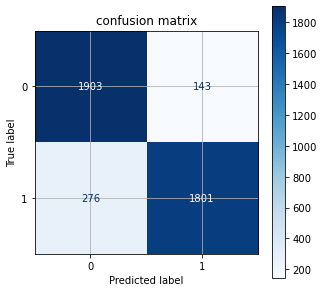

In [52]:
CM = confusion_matrix(y_test, final_model_rf_sf.predict(X_test_fs_sf))

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
# False positive rate
FPR = FP/(FP+TN)

print('Confusion Matrix:')
print('-----------------')
print(CM)
print('\n')
print('False positive rate - ',FPR)

# Plot confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,6))
disp = plot_confusion_matrix(final_model_rf_sf, X_test_fs_sf,y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
disp.ax_.set_title("confusion matrix")
plt.grid(b=None)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.show()

In [53]:
sorted_feat_imp_rf = list(zip(X_test_fs_sf.columns,final_model_rf_sf.feature_importances_))
sorted_feat_imp_rf.sort(key=lambda x: x[1],reverse = True)
pd.DataFrame(sorted_feat_imp_rf,columns = ['feature','importance']).to_csv('../first_run_rf_sf_fi.csv')

# Rough

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
# Recall
from sklearn.metrics import recall_score
recall_score(y_true, y_pred, average=None)
# Precision
from sklearn.metrics import precision_score
precision_score(y_true, y_pred, average=None)

FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  
FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
TP = np.diag(confusion_mat)
TN = confusion_mat.values.sum() - (FP + FN + TP)
        
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)        

In [56]:
df_poi = X_train.head(1)
# df1 = df.loc[:, (df > 0).all()]
df_poi = df_poi.loc[:, (df_poi != 0).all()]

In [57]:
df_poi.head(2)

,software_version_4.6,manufacturer_YITOA,model_P-WAL-107-YIT-03,sku_P-WAL-107-YIT-03,state_Texas,is_battery_charging_True,ranking_10.0,specialty_Oncology,fs_pct_0.0196_0.0239,avg_campaigns,...,Vasculature,Ventral Hernia,Ventricular Fibrillation with Conduction System,Wagner Classification,Warts on Skin,Whiteboard,Wrist,avg_times,avg_days,clinic_had_mia
asset_id,,,,,,,,,,,,,,,,,,,,,
W01Y107687,1,1,1,1,1,1,1,1,1,0.267746,...,-0.260727,-0.082145,-0.090345,-0.211962,-0.123294,-0.011374,-0.197531,1.322661,0.137164,1


In [98]:
x_asad = X_train_fs.copy()
x_asad.reset_index(inplace = True)
x_asad.groupby('clinic_had_mia')['asset_id'].nunique()

clinic_had_mia
0     2335
1    10034
Name: asset_id, dtype: int64